In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose                        
import warnings
warnings.filterwarnings("ignore")
from pmdarima import auto_arima
import matplotlib.pyplot as plt
plt.style.use('seaborn')
from simple_colors import *

# <font color='green'>EDA</font>

In [2]:
data=pd.read_csv('test_test.csv')
#data.head(2)

In [3]:
ts=pd.read_csv('time_ser.csv')
#ts.head(2)

In [4]:
statistics=pd.DataFrame()
statistics['Month']=data.index
statistics['El_trend_diff-%']=round(100-(data['2021 El_queries']/data['2020 El_queries'])*100,1)
statistics['El_visit_diff%']=round((data['2021 El_vis']/data['2020 El_vis'])*100,1)
#statistics

In [5]:
statistics=statistics.set_index('Month')
#statistics.to_csv('statistics.csv')

***

### 1.

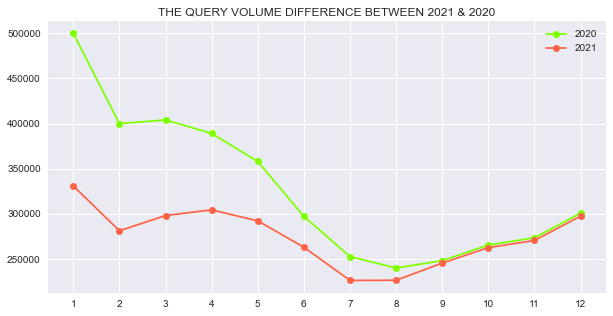

In [6]:
queries=data[['2020 El_queries','2021 El_queries']]
queries.columns=['2020','2021']
queries.plot(figsize=(10,5),marker='o',color=['chartreuse','tomato'],title='THE QUERY VOLUME DIFFERENCE BETWEEN 2021 & 2020')
x=[1,2,3,4,5,6,7,8,9,10,11,12]
xi = list(range(len(x)))
plt.xticks(xi,x)
plt.show()

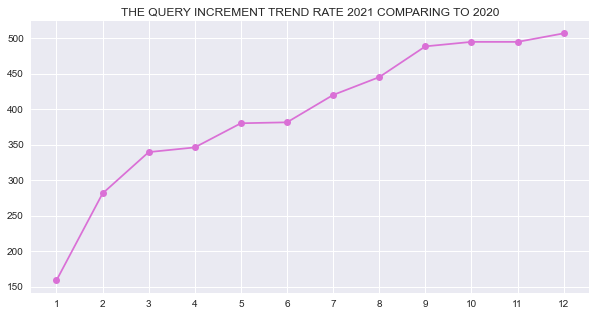

In [7]:
statistics['El_visit_diff%'].plot(figsize=(10,5),marker='o',color='orchid',xlabel=' ',title='THE QUERY INCREMENT TREND RATE 2021 COMPARING TO 2020')
x=[1,2,3,4,5,6,7,8,9,10,11,12]
xi = list(range(len(x)))
plt.xticks(xi,x)
plt.show()

In [8]:
print('The average decrease rate of search queries in 2021 is',round(statistics['El_trend_diff-%'].mean(),1),'%')

The average decrease rate of search queries in 2021 is 13.5 %


***

### 2.

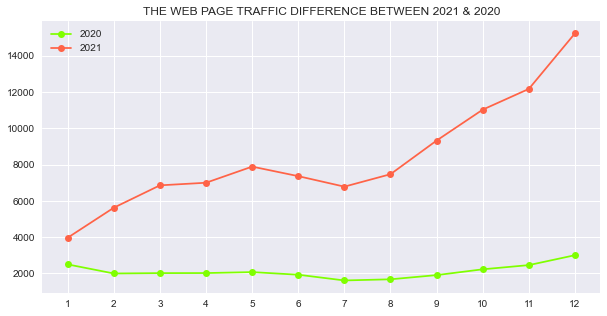

In [9]:
visits=data[['2020 El_vis','2021 El_vis']]
visits.columns=['2020','2021']
visits.plot(figsize=(10,5),marker='o',color=['chartreuse','tomato'],title='THE WEB PAGE TRAFFIC DIFFERENCE BETWEEN 2021 & 2020')
x=[1,2,3,4,5,6,7,8,9,10,11,12]
xi = list(range(len(x)))
plt.xticks(xi,x)
plt.show()

In [10]:
print('The average increae rate of visits in 2021 is',round(statistics['El_visit_diff%'].mean(),1),'%')

The average increae rate of visits in 2021 is 394.6 %


***

### 3.

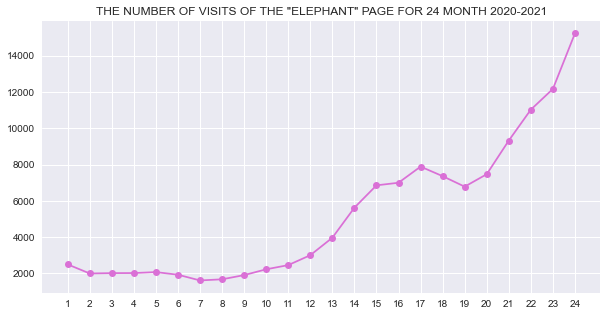

In [11]:
x=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24]
xi = list(range(len(x)))
plt.xticks(xi,x)
ts['Elephant'].plot(figsize=(10,5),marker='o',color='orchid',title='THE NUMBER OF VISITS OF THE "ELEPHANT" PAGE FOR 24 MONTH 2020-2021')
plt.show()

In [12]:
print('The average number of visits in 2020:',black(round(data['2020 El_vis'].mean()),['bold']))
print('The average number of visits in 2021:',black(round(data['2021 El_vis'].mean()),['bold']))
print('The average number of visits for 24 month of 2020-2021:',red(round(ts['Elephant'].mean()),['bold']))

The average number of visits in 2020: 2121
The average number of visits in 2021: 8392
The average number of visits for 24 month of 2020-2021: 5256


In [13]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
values=ts[['Elephant','Elephant Query']]
scaler.fit(values)
plot=scaler.transform(values)
plot=pd.DataFrame(plot)
plot.colunms=['visits','queries']
plot=plot.rename(columns={0:'visits',1:'queries'})

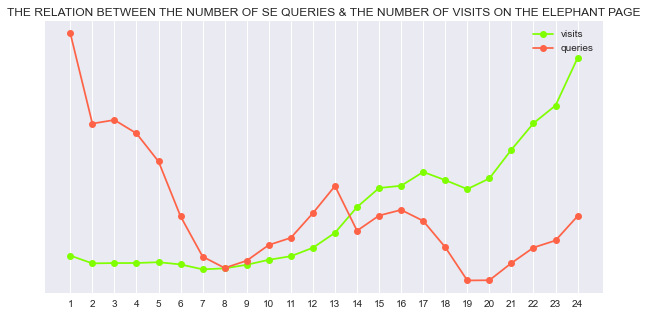

In [14]:
plot.plot(figsize=(10,5),marker='o',color=['chartreuse','tomato'],title='THE RELATION BETWEEN THE NUMBER OF SE QUERIES & THE NUMBER OF VISITS ON THE ELEPHANT PAGE')
x=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24]
xi = list(range(len(x)))
plt.xticks(xi,x)
plt.gca().yaxis.set_major_locator(plt.NullLocator())
plt.show()

In [15]:
ovrl_cor=pd.DataFrame(values.corr())
print('The overall 24 month correlation:',red(int(ovrl_cor['Elephant Query'][:1]*100)),red('%')) 

The overall 24 month correlation: -34 %


In [16]:
jan_may_cor=pd.DataFrame(values[:17].corr())
print('The correlation from January 2020 to May 2021:',red(int(jan_may_cor['Elephant Query'][:1]*100)),red('%'))

The correlation from January 2020 to May 2021: -15 %


In [17]:
june_dec_cor=pd.DataFrame(values[17:].corr())
print('The correlation from June to December 2021:',red(int(june_dec_cor['Elephant Query'][:1]*100)),red('%'))

The correlation from June to December 2021: 87 %


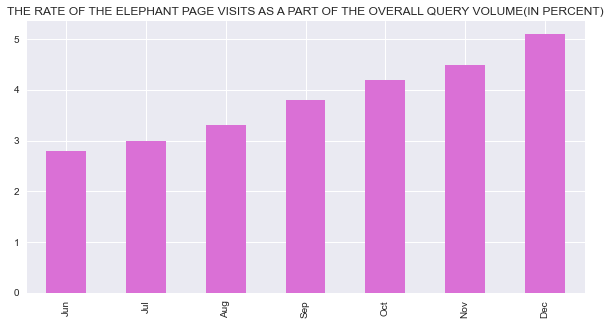

In [18]:
correlated=round((values['Elephant']/values['Elephant Query'])*100,1)[17:]
correlated.plot(kind='bar',figsize=(10,5),color='orchid',title='THE RATE OF THE ELEPHANT PAGE VISITS AS A PART OF THE OVERALL QUERY VOLUME(IN PERCENT)')
x=['Jun','Jul','Aug','Sep','Oct','Nov','Dec']
xi = list(range(len(x)))
plt.xticks(xi,x)
plt.show()

In [19]:
print('The rate of the "Elephant" page visits from the whole number of queris of the period June - December varied from',correlated.min(),'%','to',correlated.max(),'%')

The rate of the "Elephant" page visits from the whole number of queris of the period June - December varied from 2.8 % to 5.1 %


***

***

# <font color='green'>TIME SERIES ANALYSIS</font>

### 4.

In [20]:
ts_el=ts.drop(['Squirrel','Squirrel Query','Elephant Query'],axis=1)
ts_el.set_index('Month', inplace=True)
ts_el.index = pd.to_datetime(ts_el.index)
#ts_el

In [21]:
s_dec= seasonal_decompose(ts_el['Elephant'],model='additive',period=1)
#s_dec.plot()

**<font color='orchid'>ARIMA</font>**

In [22]:
oos_results = []
month_to_predict = 11
oos_train_data = ts_el
for i, col in enumerate(ts_el.columns):
    #Fit best model for each column
    s = auto_arima(oos_train_data[col], trace=True)
    oos_arima_model = SARIMAX(oos_train_data[col],
                          order = s.get_params()['order'],
                          seasonal_order = s.get_params()['seasonal_order'])
    oos_arima_result = oos_arima_model.fit()

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=359.104, Time=0.33 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=355.379, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=356.969, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=356.643, Time=0.04 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=358.214, Time=0.07 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=356.312, Time=0.01 sec

Best model:  ARIMA(0,2,0)(0,0,0)[0]          
Total fit time: 0.496 seconds
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.36384D+00    |proj g|=  1.16947D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauch

 This problem is unconstrained.


***

### 5.

**<font color='orchid'>FORECAST</font>**

In [23]:
oos_arima_pred = oos_arima_result.predict(start = len(oos_train_data),
                                          end = len(oos_train_data) + month_to_predict, typ="levels").rename("ARIMA Predictions")

In [24]:
prediction_el=pd.DataFrame(oos_arima_pred)
#prediction_el.to_csv('elephant.csv')
prediction_elp=prediction_el.transpose()
prediction_elp.columns=['January','February','March','April','May','June','July','August','September','October','November','December']
print(red('Prediction of the monthly traffic of the page "Elephant in 2022":',['bold']))
prediction_elp

Prediction of the monthly traffic of the page "Elephant in 2022":


,January,February,March,April,May,June,July,August,September,October,November,December
ARIMA Predictions,18291.0,21352.0,24413.0,27474.0,30535.0,33596.0,36657.0,39718.0,42779.0,45840.0,48901.0,51962.0


***

### 6.

In [36]:
prediction=np.array(prediction_el['ARIMA Predictions'])
vis=np.array(data['2021 El_vis'])
trend=pd.DataFrame((prediction/vis)*100)
trend_t=trend.transpose()
trend_t=round(trend_t)
trend_t.columns=['January','February','March','April','May','June','July','August','September','October','November','December']
print(red('Prediction of the monthly traffic trend of the page "Elephant in 2022":',['bold']))
trend_t=trend_t.astype(str)+'%'
trend_t

Prediction of the monthly traffic trend of the page "Elephant in 2022":


,January,February,March,April,May,June,July,August,September,October,November,December
0,461.0%,380.0%,356.0%,393.0%,387.0%,456.0%,540.0%,532.0%,459.0%,416.0%,402.0%,341.0%


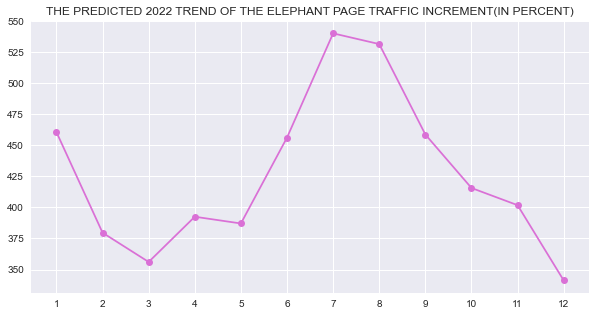

In [106]:
trend.plot(figsize=(10,5),marker='o',legend=False,color='orchid',title='THE PREDICTED 2022 TREND OF THE ELEPHANT PAGE TRAFFIC INCREMENT(IN PERCENT)')
x=[1,2,3,4,5,6,7,8,9,10,11,12]
xi = list(range(len(x)))
plt.xticks(xi,x)
plt.show()

In [109]:
trend_t=(trend_t.astype(str) + '%')
trend_t

,January,February,March,April,May,June,July,August,September,October,November,December
0,461.0%,380.0%,356.0%,393.0%,387.0%,456.0%,540.0%,532.0%,459.0%,416.0%,402.0%,341.0%


In [124]:
print('The model predicts the average monthly traffic increment to be:',red(round(trend[0].mean()),['bold']),red('%',['bold']))

The model predicts the average monthly traffic increment to be: 427 %
